In [98]:
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from scipy.integrate import solve_ivp
from typing import Callable, Tuple, List, Dict, Any
from enum import Enum
from dataclasses import dataclass

In [99]:
class IntegrationMethod(Enum):
    EULER = "euler"                # Simple first-order method
    VELOCITY_VERLET = "verlet"     # Common in molecular dynamics
    LEAPFROG = "leapfrog"         # Symplectic, good energy conservation
    RK4 = "rk4"                   # Classical 4th order Runge-Kutta
    SCIPY_RK45 = "scipy_rk45"     # Adaptive Runge-Kutta-Fehlberg
    
@dataclass
class Solution:
    """Container for integration results"""
    t: np.ndarray
    y: np.ndarray
    success: bool
    method: str
    
def euler_step(f: Callable, t: float, y: np.ndarray, dt: float, *args) -> np.ndarray:
    """Simple Euler integration"""
    return y + dt * np.array(f(t, y, *args))

def velocity_verlet_step(f: Callable, t: float, y: np.ndarray, dt: float, *args) -> np.ndarray:
    """Velocity Verlet - popular in molecular dynamics"""
    theta1, z1, theta2, z2 = y
    
    # Half-step velocity
    a1, a2 = f(t, y, *args)[1::2]  # Get accelerations
    z1_half = z1 + 0.5 * dt * a1
    z2_half = z2 + 0.5 * dt * a2
    
    # Full step position
    theta1_new = theta1 + dt * z1_half
    theta2_new = theta2 + dt * z2_half
    
    # Update accelerations
    y_temp = np.array([theta1_new, z1_half, theta2_new, z2_half])
    a1_new, a2_new = f(t + dt, y_temp, *args)[1::2]
    
    # Full step velocity
    z1_new = z1_half + 0.5 * dt * a1_new
    z2_new = z2_half + 0.5 * dt * a2_new
    
    return np.array([theta1_new, z1_new, theta2_new, z2_new])

def leapfrog_step(f: Callable, t: float, y: np.ndarray, dt: float, *args) -> np.ndarray:
    """Leapfrog integration - symplectic, good for energy conservation"""
    theta1, z1, theta2, z2 = y
    
    # Update positions by half step
    theta1_half = theta1 + 0.5 * dt * z1
    theta2_half = theta2 + 0.5 * dt * z2
    
    # Get accelerations at half step
    y_half = np.array([theta1_half, z1, theta2_half, z2])
    _, a1, _, a2 = f(t + 0.5*dt, y_half, *args)
    
    # Update velocities using acceleration at half step
    z1_new = z1 + dt * a1
    z2_new = z2 + dt * a2
    
    # Complete position update
    theta1_new = theta1_half + 0.5 * dt * z1_new
    theta2_new = theta2_half + 0.5 * dt * z2_new
    
    return np.array([theta1_new, z1_new, theta2_new, z2_new])

def rk4_step(f: Callable, t: float, y: np.ndarray, dt: float, *args) -> np.ndarray:
    """Classical 4th order Runge-Kutta"""
    k1 = np.array(f(t, y, *args))
    k2 = np.array(f(t + dt/2, y + dt*k1/2, *args))
    k3 = np.array(f(t + dt/2, y + dt*k2/2, *args))
    k4 = np.array(f(t + dt, y + dt*k3, *args))
    return y + dt * (k1 + 2*k2 + 2*k3 + k4) / 6

In [100]:



def equations_of_motion(t, y, m1, m2, L1, L2, g):
    theta1, z1, theta2, z2 = y  # z1 = dθ1/dt, z2 = dθ2/dt

    delta = theta2 - theta1
    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta) ** 2
    den2 = (L2 / L1) * den1

    # Equations for angular accelerations
    dz1dt = (
        m2 * L1 * z1 ** 2 * np.sin(delta) * np.cos(delta)
        + m2 * g * np.sin(theta2) * np.cos(delta)
        + m2 * L2 * z2 ** 2 * np.sin(delta)
        - (m1 + m2) * g * np.sin(theta1)
    ) / den1

    dz2dt = (
        -m2 * L2 * z2 ** 2 * np.sin(delta) * np.cos(delta)
        + (m1 + m2) * g * np.sin(theta1) * np.cos(delta)
        - (m1 + m2) * L1 * z1 ** 2 * np.sin(delta)
        - (m1 + m2) * g * np.sin(theta2)
    ) / den2

    return [z1, dz1dt, z2, dz2dt]

In [101]:
def simulate_double_pendulum(
    t_span: Tuple[float, float],
    y0: List[float],
    m1: float,
    m2: float,
    L1: float,
    L2: float,
    g: float,
    method: str = "scipy_rk45",
    dt: float = 0.01
) -> Solution:
    """Simulate double pendulum with various integration methods"""
    
    if method == "scipy_rk45":
        sol = solve_ivp(
            equations_of_motion,
            t_span,
            y0,
            args=(m1, m2, L1, L2, g),
            method='RK45',
            t_eval=np.linspace(t_span[0], t_span[1], int((t_span[1]-t_span[0])/dt))
        )
        return Solution(t=sol.t, y=sol.y, success=sol.success, method=method)
    
    # Custom integration methods
    t = np.arange(t_span[0], t_span[1] + dt, dt)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    
    # Select integration method
    if method == "euler":
        step_func = euler_step
    elif method == "verlet":
        step_func = velocity_verlet_step
    elif method == "leapfrog":
        step_func = leapfrog_step
    elif method == "rk4":
        step_func = rk4_step
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Integration loop
    for i in range(len(t)-1):
        y[i+1] = step_func(equations_of_motion, t[i], y[i], dt, m1, m2, L1, L2, g)
    
    return Solution(t=t, y=y.T, success=True, method=method)

In [102]:
def compute_energy(theta1, theta2, z1, z2, m1, m2, L1, L2, g):
    # Positions of the masses
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)

    # Velocities of the masses
    vx1 = L1 * z1 * np.cos(theta1)
    vy1 = L1 * z1 * np.sin(theta1)
    vx2 = vx1 + L2 * z2 * np.cos(theta2)
    vy2 = vy1 + L2 * z2 * np.sin(theta2)

    # Kinetic energy
    T1 = 0.5 * m1 * (vx1 ** 2 + vy1 ** 2)
    T2 = 0.5 * m2 * (vx2 ** 2 + vy2 ** 2)
    T = T1 + T2

    # Potential energy
    V1 = m1 * g * y1
    V2 = m2 * g * y2
    V = V1 + V2

    return T, V, T + V

In [103]:

# Modify the animate_double_pendulum function to accept a filename and save the animation
def animate_double_pendulum(sol, L1, L2, filename=None):
    theta1, theta2 = sol.y[0], sol.y[2]

    # Positions of the masses
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)

    fig, ax = plt.subplots()
    ax.set_xlim(-L1 - L2, L1 + L2)
    ax.set_ylim(-L1 - L2, L1 + L2)
    line, = ax.plot([], [], "o-", lw=2)

    def update(frame):
        line.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])
        return line,

    ani = FuncAnimation(fig, update, frames=len(x1), blit=True, interval=30)
    if filename:
        ani.save(filename, writer="ffmpeg")
        print(f"Animation saved to {filename}")
    else:
        plt.show()

In [104]:
def plot_energy(sol, m1, m2, L1, L2, g):
    theta1, z1, theta2, z2 = sol.y
    energies = [compute_energy(theta1[i], theta2[i], z1[i], z2[i], m1, m2, L1, L2, g) for i in range(len(theta1))]
    T, V, E = zip(*energies)

    plt.plot(sol.t, T, label="Kinetic Energy")
    plt.plot(sol.t, V, label="Potential Energy")
    plt.plot(sol.t, E, label="Total Energy")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Energy")
    plt.show()

In [105]:
m1, m2 = 1.0, 1.0  # Masses
L1, L2 = 1.0, 1.0  # Lengths
g = 9.81           # Gravitational acceleration
y0 = [np.pi / 2, 0, np.pi / 4, 0]  # Initial conditions: [theta1, dθ1/dt, theta2, dθ2/dt]
t_span = [0, 30]   # Time span
sol = simulate_double_pendulum(t_span, y0, m1, m2, L1, L2, g)

In [106]:
def save_simulation_data(solutions: Dict[str, Solution], m1: float, m2: float, L1: float, L2: float, g: float):
    """Convert simulation results to JSON format for web visualization"""
    import json
    
    output_data = {}
    for method, sol in solutions.items():
        theta1, z1, theta2, z2 = sol.y
        
        # Calculate positions for visualization
        x1 = L1 * np.sin(theta1)
        y1 = -L1 * np.cos(theta1)
        x2 = x1 + L2 * np.sin(theta2)
        y2 = y1 - L2 * np.cos(theta2)
        
        # Calculate energies
        energies = [float(compute_energy(theta1[i], theta2[i], z1[i], z2[i], 
                                       m1, m2, L1, L2, g)[2])
                   for i in range(len(theta1))]
        
        # Store data
        output_data[method] = {
            'times': sol.t.tolist(),
            'positions': [
                {
                    'x1': float(x1[i]),
                    'y1': float(y1[i]),
                    'x2': float(x2[i]),
                    'y2': float(y2[i])
                }
                for i in range(len(theta1))
            ],
            'energies': energies
        }
    
    # Ensure outputs directory exists
    os.makedirs('outputs', exist_ok=True)
    
    # Save to JSON file
    with open('outputs/pendulum_comparison_data.json', 'w') as f:
        json.dump(output_data, f, indent=2)
    
    print("Data saved to outputs/pendulum_comparison_data.json")

Data saved to outputs/pendulum_comparison_data.json


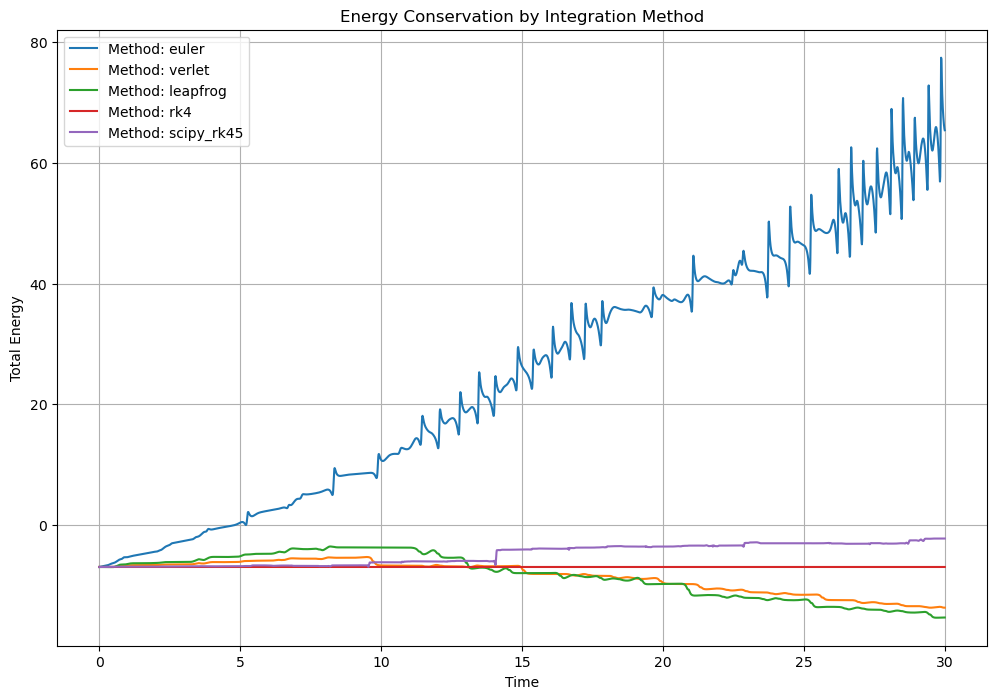

In [ ]:
# Compare different integration methods
methods = ["euler", "verlet", "leapfrog", "rk4", "scipy_rk45"]
solutions = {}

for method in methods:
    solutions[method] = simulate_double_pendulum(
        t_span=t_span,
        y0=[np.pi/2, 0, np.pi/4, 0],
        m1=1.0, m2=1.0,
        L1=1.0, L2=1.0,
        g=9.81,
        method=method,
        dt=0.01
    )
    
# Save simulation data for web visualization
save_simulation_data(
    solutions,
    m1=1.0, m2=1.0,
    L1=1.0, L2=1.0,
    g=9.81
)

# Plot energy conservation comparison
plt.figure(figsize=(12, 8))
for method in methods:
    sol = solutions[method]
    theta1, z1, theta2, z2 = sol.y
    energies = [compute_energy(theta1[i], theta2[i], z1[i], z2[i], 
                             m1, m2, L1, L2, g)[2] 
               for i in range(len(theta1))]
    plt.plot(sol.t, energies, label=f'Method: {method}')

plt.xlabel('Time')
plt.ylabel('Total Energy')
plt.legend()
plt.title('Energy Conservation by Integration Method')
plt.grid(True)
plt.show()

In [ ]:
def animate_double_pendulum_with_energy(solutions: Dict[str, Solution], L1: float, L2: float, 
                                      m1: float, m2: float, g: float, filename: str = None):
    """Animate multiple pendulum solutions with energy plots side by side"""
    
    # Setup figure and axes
    fig = plt.figure(figsize=(15, 6))
    pendulum_ax = plt.subplot(121)
    energy_ax = plt.subplot(122)
    
    # Setup pendulum plot
    pendulum_ax.set_xlim(-L1 - L2, L1 + L2)
    pendulum_ax.set_ylim(-L1 - L2, L1 + L2)
    pendulum_ax.grid(True)
    
    # Setup energy plot
    energy_ax.set_xlabel('Time')
    energy_ax.set_ylabel('Total Energy')
    energy_ax.grid(True)
    
    # Create lines for each method
    pendulum_lines = {}
    energy_lines = {}
    energy_points = {}
    
    # Get max time for energy plot
    max_time = max(sol.t[-1] for sol in solutions.values())
    energy_ax.set_xlim(0, max_time)
    
    # Color map for different methods
    colors = plt.cm.Set2(np.linspace(0, 1, len(solutions)))
    
    # Initialize plots for each method
    for (method, sol), color in zip(solutions.items(), colors):
        # Setup pendulum line
        line, = pendulum_ax.plot([], [], 'o-', lw=2, label=method, color=color)
        pendulum_lines[method] = line
        
        # Precompute energies
        theta1, z1, theta2, z2 = sol.y
        energies = [compute_energy(theta1[i], theta2[i], z1[i], z2[i], 
                                 m1, m2, L1, L2, g)[2] 
                   for i in range(len(theta1))]
        
        # Setup energy plot
        line, = energy_ax.plot([], [], '-', label=method, color=color, alpha=0.5)
        point, = energy_ax.plot([], [], 'o', color=color)
        energy_lines[method] = {'line': line, 'data': energies}
        energy_points[method] = point
    
    pendulum_ax.legend()
    energy_ax.legend()
    
    def init():
        """Initialize animation"""
        return list(pendulum_lines.values()) + list(energy_points.values())
    
    def update(frame):
        """Update animation frame"""
        for method, sol in solutions.items():
            # Update pendulum
            theta1, theta2 = sol.y[0], sol.y[2]
            x1 = L1 * np.sin(theta1[frame])
            y1 = -L1 * np.cos(theta1[frame])
            x2 = x1 + L2 * np.sin(theta2[frame])
            y2 = y1 - L2 * np.cos(theta2[frame])
            
            pendulum_lines[method].set_data([0, x1, x2], [0, y1, y2])
            
            # Update energy plot
            times = sol.t[:frame+1]
            energies = energy_lines[method]['data'][:frame+1]
            energy_lines[method]['line'].set_data(times, energies)
            energy_points[method].set_data([times[-1]], [energies[-1]])
        
        return list(pendulum_lines.values()) + list(energy_points.values())
    
    # Create animation
    ani = FuncAnimation(fig, update, frames=min(len(sol.t) for sol in solutions.values()),
                       init_func=init, interval=30, blit=True)
    
    if filename:
        ani.save(filename, writer='ffmpeg', dpi=100)
        print(f"Animation saved to {filename}")
        
    return ani

# Example usage:
methods = ["euler", "verlet", "leapfrog", "rk4"]
solutions = {}

# Create outputs directory
os.makedirs("outputs", exist_ok=True)

# Simulate with different methods
for method in methods:
    solutions[method] = simulate_double_pendulum(
        t_span=t_span,
        y0=[np.pi/2, 0, np.pi/4, 0],
        m1=1.0, m2=1.0,
        L1=1.0, L2=1.0,
        g=9.81,
        method=method,
        dt=0.01
    )




In [109]:
print(solutions)

{'euler': Solution(t=array([ 0.  ,  0.01,  0.02, ...,  9.98,  9.99, 10.  ]), y=array([[ 1.57079633e+00,  1.57079633e+00,  1.56981533e+00, ...,
        -4.00924723e-01, -4.60574865e-01, -5.19020630e-01],
       [ 0.00000000e+00, -9.81000000e-02, -1.96232079e-01, ...,
        -5.96501412e+00, -5.84457653e+00, -5.74797629e+00],
       [ 7.85398163e-01,  7.85398163e-01,  7.85398163e-01, ...,
         9.23762438e-01,  9.47360816e-01,  9.66432129e-01],
       [ 0.00000000e+00,  1.18423789e-17,  9.07322652e-05, ...,
         2.35983782e+00,  1.90713133e+00,  1.47475258e+00]]), success=True, method='euler'), 'verlet': Solution(t=array([ 0.  ,  0.01,  0.02, ...,  9.98,  9.99, 10.  ]), y=array([[ 1.57079633e+00,  1.57030583e+00,  1.56883397e+00, ...,
         4.78094575e-01,  4.95165099e-01,  5.11729080e-01],
       [ 0.00000000e+00, -9.81120275e-02, -1.96304278e-01, ...,
         1.73335828e+00,  1.68148216e+00,  1.63192657e+00],
       [ 7.85398163e-01,  7.85398163e-01,  7.85399184e-01, ...,
 

In [110]:
# # Generate animation
# filename = "outputs/pendulum_comparison.mp4"
# ani = animate_double_pendulum_with_energy(
#     solutions,
#     L1=1.0,
#     L2=1.0,
#     m1=1.0,
#     m2=1.0,
#     g=9.81,
#     filename=filename
# )

# # Save in multiple formats
# files = save_animation(ani, "pendulum_comparison")

In [111]:
def save_animation(ani: FuncAnimation, filename: str, fps: int = 30, dpi: int = 100) -> Dict[str, str]:
    """Save animation in multiple formats optimized for web"""
    
    # Ensure outputs directory exists
    os.makedirs("outputs", exist_ok=True)
    
    # Base filename without extension
    base = os.path.splitext(filename)[0]
    
    # Save WebM as primary format
    webm_file = f"{base}.webm"
    ani.save(f"outputs/{webm_file}", 
            writer='ffmpeg',
            fps=fps,
            dpi=dpi,
            codec='libvpx-vp9',
            bitrate='2000k',
            extra_args=['-crf', '30'])
    
    # Save MP4 as fallback
    mp4_file = f"{base}.mp4"
    ani.save(f"outputs/{mp4_file}",
            writer='ffmpeg',
            fps=fps,
            dpi=dpi,
            codec='h264',
            bitrate='2000k')
    
    print(f"Animations saved as {webm_file} and {mp4_file}")
    return {'webm': webm_file, 'mp4': mp4_file}

# # Update the animation generation code
# base_filename = "pendulum_comparison"
# ani = animate_double_pendulum_with_energy(
#     solutions,
#     L1=1.0,
#     L2=1.0,
#     m1=1.0,
#     m2=1.0,
#     g=9.81,
#     filename=None  # Don't save in the animation function
# )

# # Save using the new function
# files = save_animation(ani, base_filename)